In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import os
from PIL import Image

from pathlib import Path
import numpy as np

def create_dir(folder):
    os.makedirs(folder, exist_ok=True)

def save_mask(target_folder, filename, mask):
    name = Path(filename).name
    create_dir(target_folder)
    np.save(f"{target_folder}/{name.replace('.png','_mask')}", mask)
    
def apply_mask_to_image(filename, poly_mask):
    base = Image.open(filename)
    mask = Image.fromarray((255-poly_mask[:,:,1]*255).astype(np.uint8))
    colored = Image.new('RGB', base.size, (255,0,0))
    return Image.composite(base, colored, mask)
    
    
def save_masked(target_folder, filename, mask):
    name = Path(filename).name.replace('.png','_overlayed.png')
    create_dir(target_folder)
    masked = apply_mask_to_image(filename, mask)
    masked.save(f"{target_folder}/{name}")

In [4]:
from tqdm import tqdm

from source_torch.dataset import EyeDataset

dataset = EyeDataset('../data/train_dataset/', )

# target_masks = '../data/train_masks/'
# target_masked = '../data/train_masked/'
# for item in tqdm(dataset):
#     save_mask(target_masks, item['filename'], item['mask'])
#     save_masked(target_masked, item['filename'], item['mask'])

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


Found unique files: 660
Found images with annotations: 652
Images without annotations: 3
{'../data/train_dataset/257', '../data/train_dataset/647', '../data/train_dataset/176'}
Annotations without images: 5
{'../data/train_dataset/688', '../data/train_dataset/113', '../data/train_dataset/72', '../data/train_dataset/393', '../data/train_dataset/527'}


/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [21]:
dataset2._image_files.index('../data/train_dataset/1.png')

375

In [20]:
dataset._image_files[0]

'../data/train_dataset/1.png'

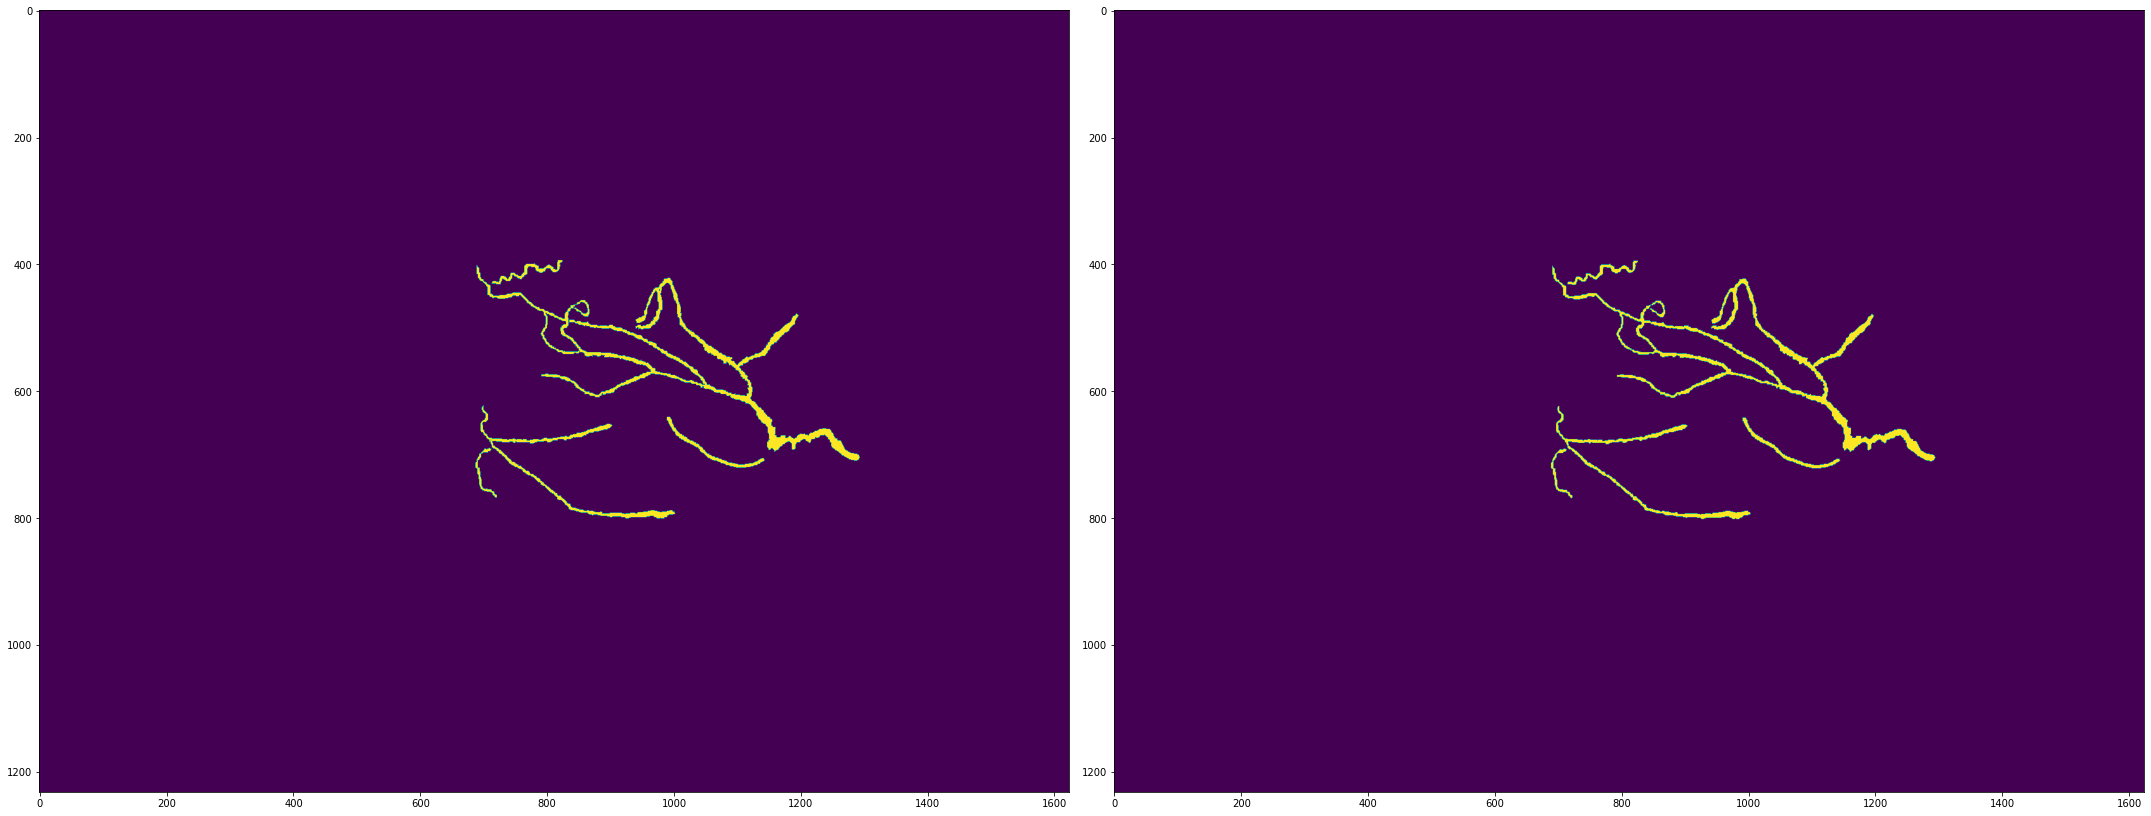

In [39]:
index = np.random.randint(len(dataset2))
puppet = (dataset2[index]['mask'][:,:,1]*255).astype(np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, [2,2])
res = cv2.morphologyEx(puppet, cv2.MORPH_CLOSE, kernel)

fig, ax = plt.subplots(1,2,figsize=(30,30))
ax[0].imshow(puppet)
ax[1].imshow(res)
plt.tight_layout()

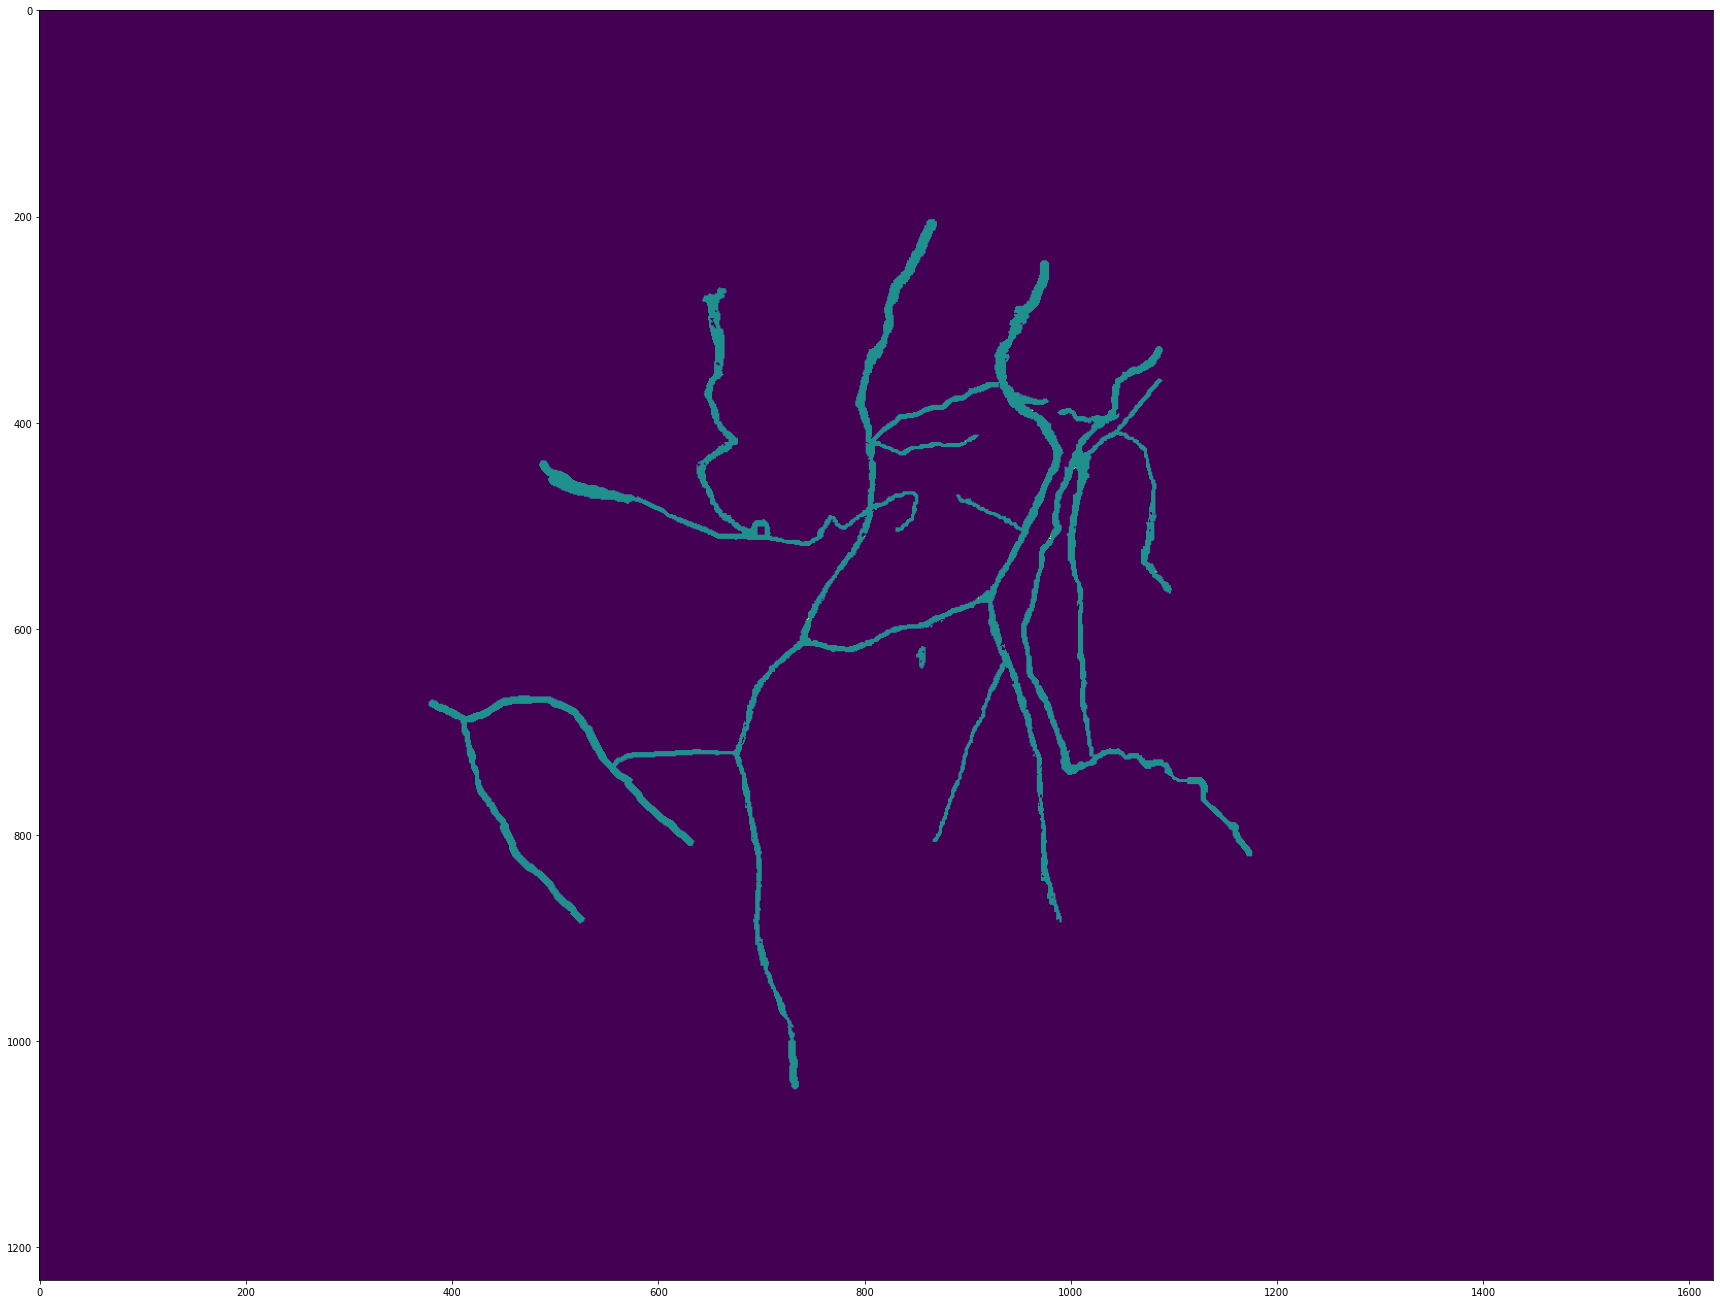

In [27]:
plt.figure(figsize=(30,30))
plt.imshow((dataset2[375]['mask'][:,:,1]*255))

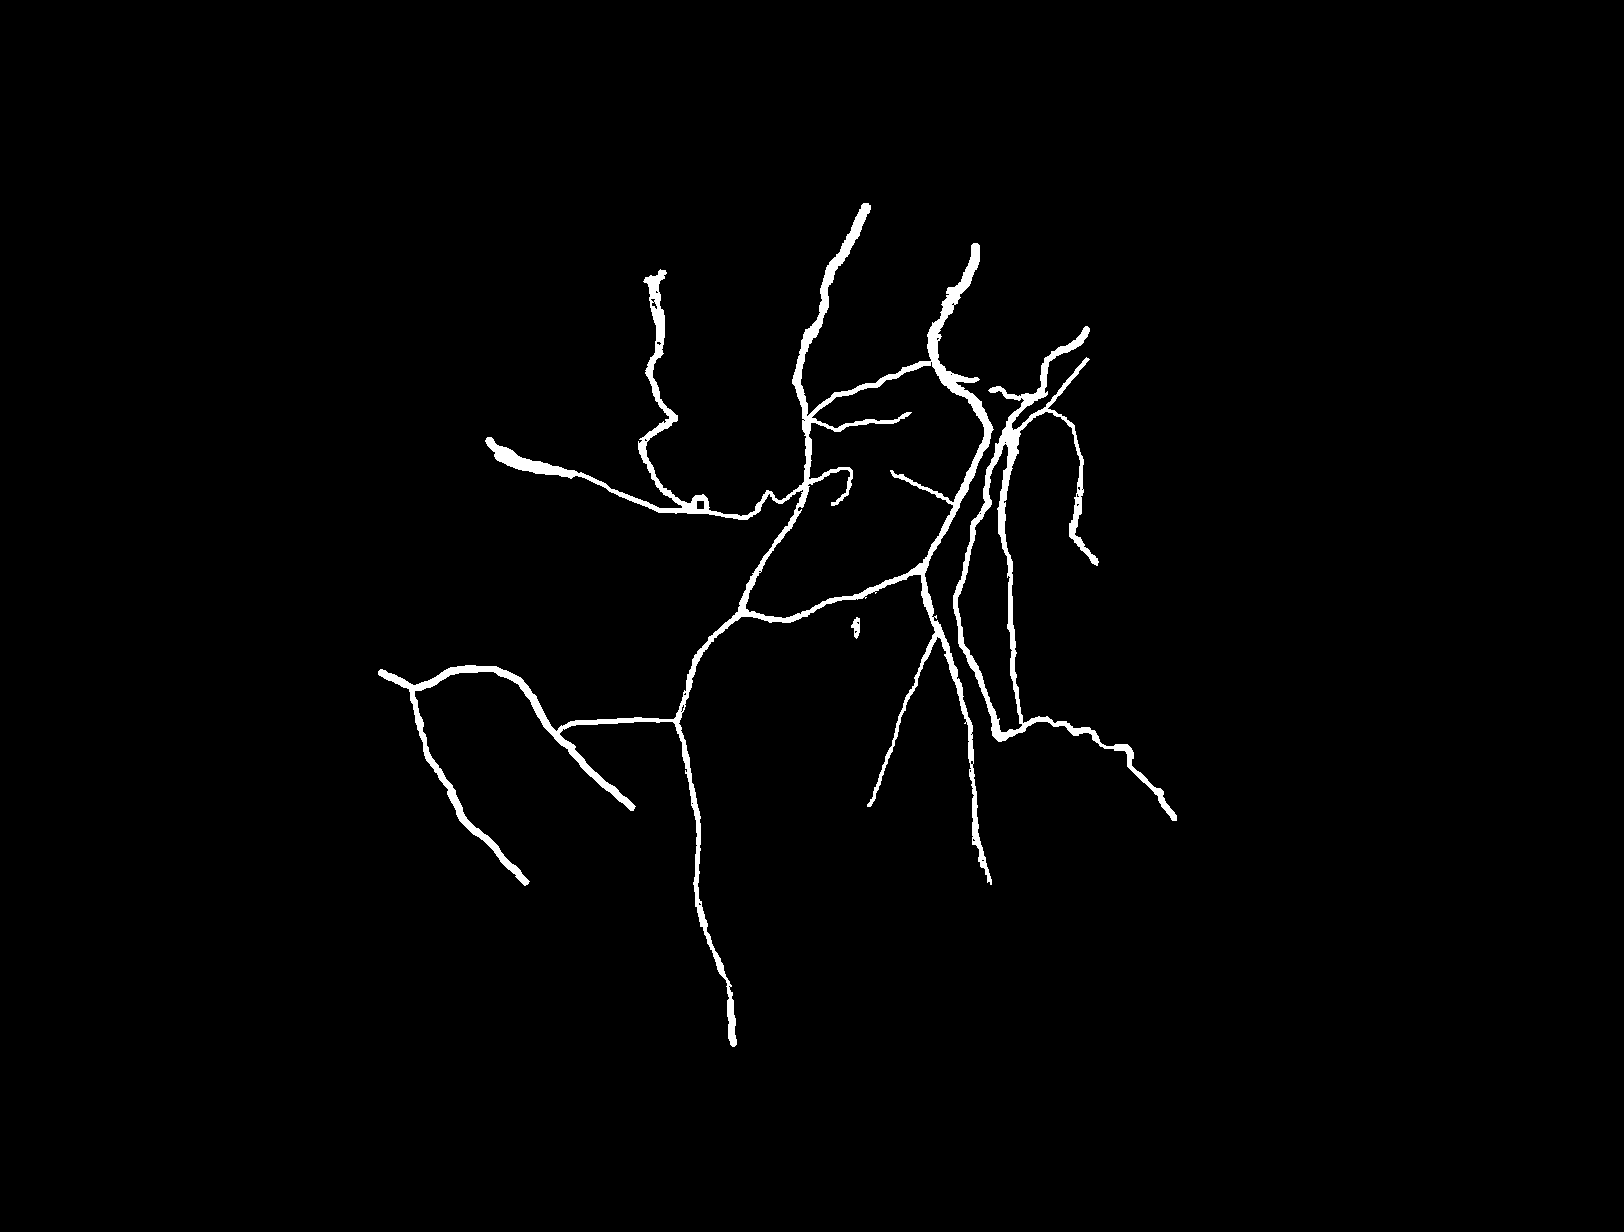

In [10]:
Image.fromarray((dataset[0]['mask'][:,:,1]*255).astype(np.uint8))

In [6]:
item['filename']

'../data/train_dataset/724.png'

In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.utils import draw_segmentation_masks

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

import json

In [12]:



class EyeDataset(Dataset):
    """
    Класс датасета, организующий загрузку и получение изображений и соответствующих разметок
    """

    def __init__(self, data_folder: str, transform = None):
        self.class_ids = {"vessel": 1}

        self.data_folder = data_folder
        self.transform = transform
        self._image_files = glob.glob(f"{data_folder}/*.png")

    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image

    @staticmethod 
    def parse_polygon(coordinates, image_size): 
        mask = np.zeros(image_size, dtype=np.float32) 
    
        if len(coordinates) == 1: 
            points = [np.int32(coordinates)] 
            cv2.fillPoly(mask, points, 1) 
        else: 
            points = [np.int32([coordinates[0]])] 
            cv2.fillPoly(mask, points, 1) 
    
            for polygon in coordinates[1:]: 
                points = [np.int32([polygon])] 
                cv2.fillPoly(mask, points, 0) 
    
        return mask

    @staticmethod
    def parse_mask(shape: dict, image_size: tuple) -> np.ndarray:
        """
        Метод для парсинга фигур из geojson файла
        """
        mask = np.zeros(image_size, dtype=np.float32)
        coordinates = shape['coordinates']
        if shape['type'] == 'MultiPolygon':
            for polygon in coordinates:
                mask += EyeDataset.parse_polygon(polygon, image_size)
        else:
            mask += EyeDataset.parse_polygon(coordinates, image_size)

        return mask

    def read_layout(self, path: str, image_size: tuple) -> np.ndarray:
        """
        Метод для чтения geojson разметки и перевода в numpy маску
        """
        with open(path, 'r', encoding='cp1251') as f:  # some files contain cyrillic letters, thus cp1251
            json_contents = json.load(f)

        num_channels = 1 + max(self.class_ids.values())
        mask_channels = [np.zeros(image_size, dtype=np.float32) for _ in range(num_channels)]
        mask = np.zeros(image_size, dtype=np.float32)

        if type(json_contents) == dict and json_contents['type'] == 'FeatureCollection':
            features = json_contents['features']
        elif type(json_contents) == list:
            features = json_contents
        else:
            features = [json_contents]

        for shape in features:
            channel_id = self.class_ids["vessel"]
            mask = self.parse_mask(shape['geometry'], image_size)
            mask_channels[channel_id] = np.maximum(mask_channels[channel_id], mask)

        mask_channels[0] = 1 - np.max(mask_channels[1:], axis=0)

        return np.stack(mask_channels, axis=-1)

    def __getitem__(self, idx: int) -> dict:
        # Достаём имя файла по индексу
        image_path = self._image_files[idx]

        # Получаем соответствующий файл разметки
        json_path = image_path.replace("png", "geojson")

        image = self.read_image(image_path)

        mask = self.read_layout(json_path, image.shape[:2])

        sample = {'image': image,
                  'mask': mask}

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self):
        return len(self._image_files)

    # Метод для проверки состояния датасета
    def make_report(self):
      reports = []
      if (not self.data_folder):
        reports.append("Путь к датасету не указан")
      if (len(self._image_files) == 0):
        reports.append("Изображения для распознавания не найдены")
      else:
        reports.append(f"Найдено {len(self._image_files)} изображений")
      cnt_images_without_masks = sum([1 - len(glob.glob(filepath.replace("png", "geojson"))) for filepath in self._image_files])
      if cnt_images_without_masks > 0:
        reports.append(f"Найдено {cnt_images_without_masks} изображений без разметки")
      else:
        reports.append(f"Для всех изображений есть файл разметки")
      return reports


class DatasetPart(Dataset):
    """
    Обертка над классом датасета для его разбиения на части
    """
    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.Compose = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self) -> int:
        return len(self.indices)


In [13]:
dataset2 = EyeDataset('../data/train_dataset/')

In [16]:
dataset2[0]

{'image': array([[[0.00392157, 0.        , 0.00392157],
         [0.        , 0.        , 0.        ],
         [0.00392157, 0.        , 0.        ],
         ...,
         [0.00392157, 0.        , 0.        ],
         [0.00392157, 0.        , 0.        ],
         [0.00392157, 0.        , 0.        ]],
 
        [[0.00392157, 0.        , 0.        ],
         [0.00784314, 0.        , 0.        ],
         [0.00392157, 0.        , 0.        ],
         ...,
         [0.00784314, 0.        , 0.        ],
         [0.00392157, 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.00392157, 0.        , 0.        ],
         [0.00392157, 0.        , 0.        ],
         [0.00392157, 0.        , 0.        ],
         ...,
         [0.00784314, 0.00392157, 0.        ],
         [0.00392157, 0.        , 0.00392157],
         [0.        , 0.        , 0.        ]],
 
        ...,
 
        [[0.        , 0.        , 0.01568628],
         [0.        , 0.        